<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v13b_customFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v13(b): Review of Custom Fit function
I've just discovered that the learning curve now looks quite different whether using the standard `model.fit()` or the custom `fit()` functions. That suggests a bug in my custom fit function.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# experiments are all related to the library as at a particular state
!cd repo && git checkout 9d09816
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

Cloning into 'repo'...
remote: Enumerating objects: 1028, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 1028 (delta 29), reused 31 (delta 15), pack-reused 977 (from 1)
Receiving objects: 100% (1028/1028), 45.11 MiB | 8.63 MiB/s, done.
Resolving deltas: 100% (626/626), done.
Updating files: 100% (33/33), done.
Note: switching to '9d09816'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 9d09816 Bug fixes
You are not currently on a branch.
Pleas

<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [2]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [3]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup


train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


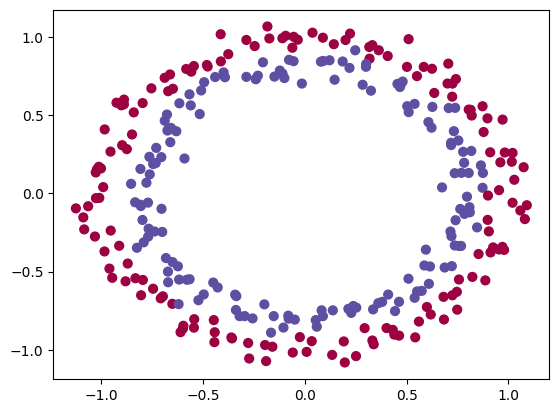

In [4]:
def plot_fit(history, per_step=None):
  plt.figure(layout='constrained')
  if per_step == True or (per_step is None and history.per_step):
    plt.plot(history.step_history['loss'])
    plt.xlabel('step')
  elif hasattr(history, 'epoch_stats'):
    tot._plot_add_quantiles(history.epoch, history.epoch_stats['loss'])
  else:
    plt.plot(history.history['loss'])
    plt.xlabel('epoch')
  plt.title('Loss')
  plt.yscale('log')
  plt.show()

def plot_fits(history_std, history_cust, per_step=None):
  plt.figure(figsize=(10,3), layout='constrained')

  plt.subplot(1,2,1)
  plt.title('Standard model.fit()')
  if per_step == True or (per_step is None and history_std.per_step):
    plt.plot(history_std.step_history['loss'])
    plt.xlabel('step')
  elif hasattr(history_std, 'epoch_stats'):
    tot._plot_add_quantiles(history_std.epoch, history_std.epoch_stats['loss'])
  else:
    plt.plot(history_std.history['loss'])
    plt.xlabel('epoch')
  plt.yscale('log')

  plt.subplot(1,2,2)
  plt.title('Custom fit()')
  if per_step == True or (per_step is None and history_cust.per_step):
    plt.plot(history_cust.step_history['loss'])
    plt.xlabel('step')
  elif hasattr(history_cust, 'epoch_stats'):
    tot._plot_add_quantiles(history_cust.epoch, history_cust.epoch_stats['loss'])
  else:
    plt.plot(history_cust.history['loss'])
    plt.xlabel('epoch')
  plt.yscale('log')

  plt.show()


def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

## Baseline
We'll want to be able to compare different versions very accurately, over multiple runs. So let's set up ourselves for that.

In [5]:
def run_multi(num_trials=10, func=None):
  """
  Args:
    func - function, must return a HistoryStats instance configured with per_step
  Returns:
    dataframe containing percentiles over per_step loss.
  """
  loss_histories = []
  q = [0, 25, 50, 75, 100]

  for n in range(num_trials):
    print(f".........Running trial {n+1}/{num_trials}.........")
    hist = func()
    loss_histories.append(hist.step_history['loss'])
  print(f".........{num_trials} trials completed............")

  # compute percentiles
  # - stack into shape: (iterations, trials)
  # - then compute into (iterations, stats)
  loss_histories = np.stack(loss_histories, axis=1)
  percentiles = tf.transpose(tfp.stats.percentile(loss_histories, q=q, axis=1))
  return pd.DataFrame(percentiles, columns=q)

def dummy_trial():
  data = tf.abs(tf.random.normal(shape=(100,)))
  hist = tot.HistoryStats(per_step=True)
  hist.on_epoch_begin(0, {'loss': 0})
  for step, loss in enumerate(data):
    hist.on_train_batch_end(step, logs={'loss': loss.numpy()})
  return hist

def plot_trials(df, num_trials, title=None, part=False, y_lim=None):
  if title is None:
    title = f"Losses over {num_trials} trials"
  plt.title(title)
  plt.yscale('log')
  if y_lim is not None:
    plt.ylim(y_lim)
  tot._plot_add_quantiles(df.index, df)
  if not part:
    plt.show()

def compare_trials(stats1, stats2, stats2_name, num_trials=10):
  # pick common range as narrow common band between their mins and maxs
  min1, max1 = np.min(stats1.to_numpy()), np.max(stats1.to_numpy())
  min2, max2 = np.min(stats2.to_numpy()), np.max(stats2.to_numpy())
  y_min = max(min1, min2)
  y_max = min(max1, max2)

  plt.figure(figsize=(10,3), layout='constrained')
  plt.subplot(1,2,1)
  plot_trials(stats1, num_trials, title="Losses over 10 trials with standard model.fit()", part=True, y_lim=(y_min, y_max))
  plt.subplot(1,2,2)
  plot_trials(stats2, num_trials, title=f"Losses over 10 trials with {stats2_name}", part=True, y_lim=(y_min, y_max))
  plt.show()

.........Running trial 1/10.........
.........Running trial 2/10.........
.........Running trial 3/10.........
.........Running trial 4/10.........
.........Running trial 5/10.........
.........Running trial 6/10.........
.........Running trial 7/10.........
.........Running trial 8/10.........
.........Running trial 9/10.........
.........Running trial 10/10.........
.........10 trials completed............
.........Running trial 1/10.........
.........Running trial 2/10.........
.........Running trial 3/10.........
.........Running trial 4/10.........
.........Running trial 5/10.........
.........Running trial 6/10.........
.........Running trial 7/10.........
.........Running trial 8/10.........
.........Running trial 9/10.........
.........Running trial 10/10.........
.........10 trials completed............


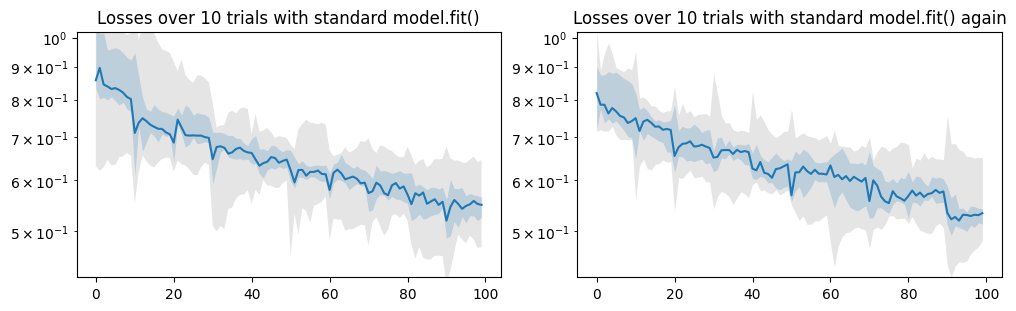

In [6]:
# standard model.fit()
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
def one_trial():
  model = binary_classification_model('he_normal')
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model.fit(dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.HistoryStats(per_step=True)])

std_trial_stats = run_multi(num_trials=10, func=one_trial)
#plot_trials(std_trial_stats, num_trials=10, title="Losses over 10 trials with standard model.fit()")

std_trial_stats2 = run_multi(num_trials=10, func=one_trial)
#plot_trials(std_trial_stats2, num_trials=10, title="Losses over 10 trials with standard model.fit() again")

compare_trials(std_trial_stats, std_trial_stats2, "standard model.fit() again", num_trials=10)


## Compare with most basic callbacks
Using currently committed fit functions as-is.

Epoch     1 - 3.29s/epoch: loss: 0.7844  
Epoch     2 - 42.18ms/epoch: loss: 0.7600  
Epoch     3 - 43.61ms/epoch: loss: 0.7326  
Epoch     4 - 40.17ms/epoch: loss: 0.6393  
Epoch     5 - 39.10ms/epoch: loss: 0.6740  
Epoch     6 - 67.64ms/epoch: loss: 0.6707  
Epoch     7 - 39.21ms/epoch: loss: 0.5807  
Epoch     8 - 62.90ms/epoch: loss: 0.6008  
Epoch     9 - 52.91ms/epoch: loss: 0.5593  
Epoch    10 - 39.79ms/epoch: loss: 0.6387  
Training via custom fit() function. Will produce a few warnings; you can usually ignore these.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_275']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_275']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


Epoch     1 - 3.61s/epoch: loss: 0.7136  
Epoch     2 - 73.94ms/epoch: loss: 0.6501  
Epoch     3 - 79.59ms/epoch: loss: 0.6375  
Epoch     4 - 63.34ms/epoch: loss: 0.6335  
Epoch     5 - 76.10ms/epoch: loss: 0.6238  
Epoch     6 - 73.49ms/epoch: loss: 0.6094  
Epoch     7 - 160.76ms/epoch: loss: 0.6024  
Epoch     8 - 70.32ms/epoch: loss: 0.5840  
Epoch     9 - 38.58ms/epoch: loss: 0.5812  
Epoch    10 - 38.95ms/epoch: loss: 0.5635  


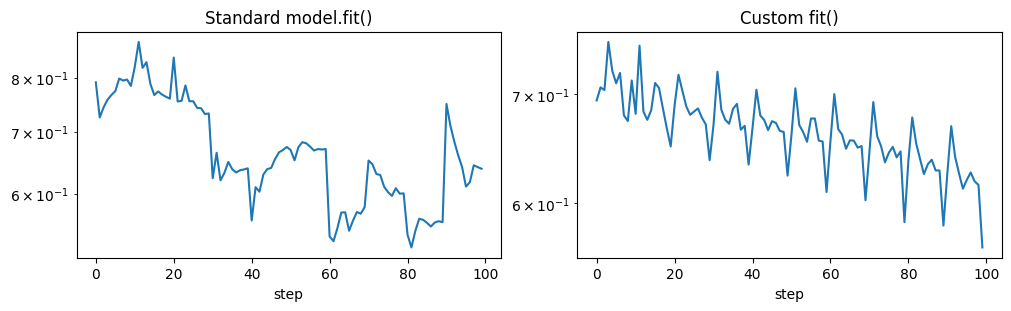

In [7]:
reload(tot)
tf.config.run_functions_eagerly(False)

# standard model.fit()
model_std = binary_classification_model('he_normal')
model_std.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_std = model_std.fit(dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = tot.fit(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

In [ ]:
# custom fit()
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
def one_trial():
  model = binary_classification_model('he_normal')
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return tot.fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.HistoryStats(per_step=True)])

cust_trial_stats = run_multi(num_trials=10, func=one_trial)
compare_trials(std_trial_stats, cust_trial_stats, "tot.fit()", num_trials=10)

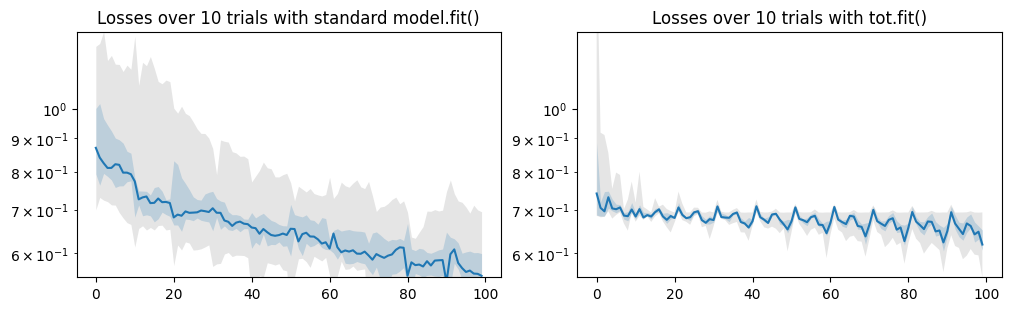

In [ ]:
compare_trials(std_trial_stats, cust_trial_stats, "tot.fit()", num_trials=10)

## Simplified custom fit function
Let's revert to a much simpler custom fit function and compare again.
This first one still splits the model out in order to get access to its individual layers.

Epoch     1 - 3.65s/epoch: loss: 0.6883  
Epoch     2 - 35.04ms/epoch: loss: 0.6206  
Epoch     3 - 34.04ms/epoch: loss: 0.6142  
Epoch     4 - 33.67ms/epoch: loss: 0.5771  
Epoch     5 - 34.69ms/epoch: loss: 0.5667  
Epoch     6 - 34.73ms/epoch: loss: 0.5438  
Epoch     7 - 38.72ms/epoch: loss: 0.5393  
Epoch     8 - 35.99ms/epoch: loss: 0.5423  
Epoch     9 - 34.63ms/epoch: loss: 0.5134  
Epoch    10 - 64.69ms/epoch: loss: 0.5026  
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_176']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_176']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


Epoch     1 - 2.81s/epoch: loss: 0.6984  
Epoch     2 - 70.63ms/epoch: loss: 0.6997  
Epoch     3 - 71.00ms/epoch: loss: 0.7004  
Epoch     4 - 37.96ms/epoch: loss: 0.6844  
Epoch     5 - 38.05ms/epoch: loss: 0.6908  
Epoch     6 - 35.58ms/epoch: loss: 0.6544  
Epoch     7 - 36.46ms/epoch: loss: 0.6622  
Epoch     8 - 70.41ms/epoch: loss: 0.6483  
Epoch     9 - 36.93ms/epoch: loss: 0.6369  
Epoch    10 - 38.21ms/epoch: loss: 0.6304  


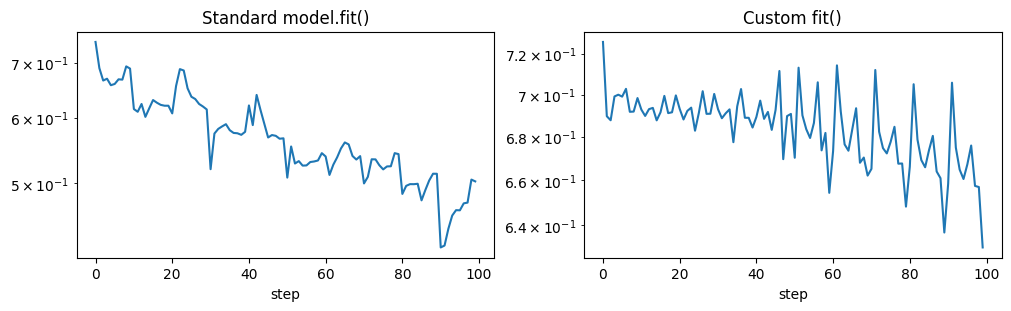

In [ ]:
def fit(model, dataset, epochs=1, verbose=1, callbacks=None, initial_epoch=0):
    # prepare epochs
    num_batches = len(dataset)

    # prepare callbacks tracking
    if not isinstance(callbacks, tf.keras.callbacks.CallbackList):
      callbacks = tf.keras.callbacks.CallbackList(callbacks, add_history=True, add_progbar=verbose != 0,
                                                  verbose=verbose, epochs=epochs, steps=num_batches, model=model)

    monitoring_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=[model.outputs] + [layer.output for layer in model.layers])

    # prepare train function
    if tf.config.functions_run_eagerly():
        train_step_fn = _gradient_returning_train_step
    else:
        train_step_fn = tf.function(_gradient_returning_train_step)

    # latest values
    # - these are computed at each step, but we need to provide values at the end of each epoch,
    #   so we'll just hold onto the last value computed at each step
    logs = {}
    loss = None
    trainable_gradients = None
    output_gradients = None
    activations = None

    # train
    print(f"Temporary custom fit() function")
    callbacks.on_train_begin()
    for epoch in range(initial_epoch, epochs):
        model.reset_metrics()
        callbacks.on_epoch_begin(epoch)

        for step, data in enumerate(dataset):
            x, y, sample_weight = keras.utils.unpack_x_y_sample_weight(data)
            callbacks.on_train_batch_begin(step)
            loss, metrics, trainable_gradients, output_gradients, activations = train_step_fn(
                model, monitoring_model, x, y, sample_weight, compute_output_gradients=False)

            logs = metrics
            logs['loss'] = loss.numpy()
            callbacks.on_train_batch_end(step, logs)

        # end of epoch
        callbacks.on_epoch_end(epoch, logs)  # should be passing loss and mse
    callbacks.on_train_end(logs)
    return model.history

def _gradient_returning_train_step(model, monitoring_model, x, y, sample_weight, compute_output_gradients):
    # Forward pass
    with tf.GradientTape() as tape:
        monitoring_outputs = monitoring_model(x)
        y_pred = monitoring_outputs[0]
        layer_outputs = monitoring_outputs[1:]

        loss = model.compute_loss(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight, training=True)
        reported_loss = loss  # tracking before scaling
        loss = model.optimizer.scale_loss(loss)

    # Backward pass
    if compute_output_gradients:
        gradients = tape.gradient(loss, model.trainable_weights + layer_outputs)
        trainable_grads = gradients[:len(model.trainable_variables)]
        output_grads = gradients[len(model.trainable_variables):]
    else:
        trainable_grads = tape.gradient(loss, model.trainable_variables)
        output_grads = None
    model.optimizer.apply_gradients(zip(trainable_grads, model.trainable_variables))

    # Metrics
    metrics = model.compute_metrics(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight)

    return reported_loss, metrics, trainable_grads, output_grads, layer_outputs

# standard model.fit()
model_std = binary_classification_model('he_normal')
model_std.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_std = model_std.fit(dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

Let's simplify even further and remove the layer access.

Epoch     1 - 2.94s/epoch: loss: 0.7778  
Epoch     2 - 34.17ms/epoch: loss: 0.7161  
Epoch     3 - 32.69ms/epoch: loss: 0.6329  
Epoch     4 - 32.60ms/epoch: loss: 0.6817  
Epoch     5 - 32.50ms/epoch: loss: 0.5985  
Epoch     6 - 32.65ms/epoch: loss: 0.5995  
Epoch     7 - 32.37ms/epoch: loss: 0.5498  
Epoch     8 - 45.98ms/epoch: loss: 0.5408  
Epoch     9 - 34.26ms/epoch: loss: 0.5464  
Epoch    10 - 32.80ms/epoch: loss: 0.5331  
Temporary custom fit() function
Epoch     1 - 2.62s/epoch: loss: 0.7223  
Epoch     2 - 48.11ms/epoch: loss: 0.7014  
Epoch     3 - 32.71ms/epoch: loss: 0.6761  
Epoch     4 - 32.77ms/epoch: loss: 0.6487  
Epoch     5 - 32.18ms/epoch: loss: 0.6367  
Epoch     6 - 31.70ms/epoch: loss: 0.6277  
Epoch     7 - 34.82ms/epoch: loss: 0.6219  
Epoch     8 - 32.25ms/epoch: loss: 0.6093  
Epoch     9 - 33.52ms/epoch: loss: 0.5997  
Epoch    10 - 34.79ms/epoch: loss: 0.5901  


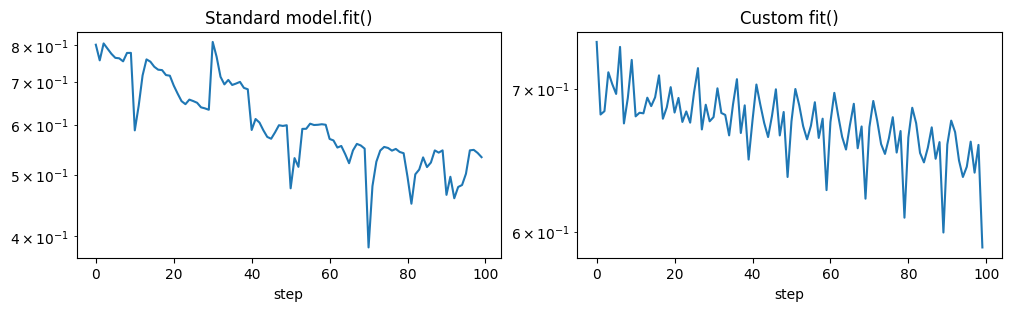

In [ ]:
def fit(model, dataset, epochs=1, verbose=1, callbacks=None, initial_epoch=0):
    # prepare epochs
    num_batches = len(dataset)

    # prepare callbacks tracking
    if not isinstance(callbacks, tf.keras.callbacks.CallbackList):
      callbacks = tf.keras.callbacks.CallbackList(callbacks, add_history=True, add_progbar=verbose != 0,
                                                  verbose=verbose, epochs=epochs, steps=num_batches, model=model)

    # prepare train function
    if tf.config.functions_run_eagerly():
        train_step_fn = _gradient_returning_train_step
    else:
        train_step_fn = tf.function(_gradient_returning_train_step)

    # latest values
    # - these are computed at each step, but we need to provide values at the end of each epoch,
    #   so we'll just hold onto the last value computed at each step
    logs = {}
    loss = None
    trainable_gradients = None
    output_gradients = None
    activations = None

    # train
    print(f"Temporary custom fit() function")
    callbacks.on_train_begin()
    for epoch in range(initial_epoch, epochs):
        model.reset_metrics()
        callbacks.on_epoch_begin(epoch)

        for step, data in enumerate(dataset):
            x, y, sample_weight = keras.utils.unpack_x_y_sample_weight(data)
            callbacks.on_train_batch_begin(step)
            loss, metrics, trainable_gradients = train_step_fn(model, x, y, sample_weight)

            logs = metrics
            logs['loss'] = loss.numpy()
            callbacks.on_train_batch_end(step, logs)

        # end of epoch
        callbacks.on_epoch_end(epoch, logs)  # should be passing loss and mse
    callbacks.on_train_end(logs)
    return model.history

def _gradient_returning_train_step(model, x, y, sample_weight):
    # Forward pass
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = model.compute_loss(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight, training=True)
        reported_loss = loss  # tracking before scaling
        loss = model.optimizer.scale_loss(loss)

    # Backward pass
    trainable_grads = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(trainable_grads, model.trainable_variables))

    # Metrics
    metrics = model.compute_metrics(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight)
    return reported_loss, metrics, trainable_grads

# standard model.fit()
model_std = binary_classification_model('he_normal')
model_std.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_std = model_std.fit(dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

Epoch   100 - 75.82ms/epoch: loss: 0.2197  
Epoch   200 - 38.43ms/epoch: loss: 0.0638  
Epoch   300 - 38.79ms/epoch: loss: 0.0275  
Epoch   400 - 45.77ms/epoch: loss: 0.0343  
Epoch   500 - 37.94ms/epoch: loss: 0.0287  
Epoch   600 - 39.17ms/epoch: loss: 0.0300  
Epoch   700 - 45.46ms/epoch: loss: 0.0109  
Epoch   800 - 40.70ms/epoch: loss: 0.0333  
Epoch   900 - 37.29ms/epoch: loss: 0.0126  
Epoch  1000 - 47.20ms/epoch: loss: 0.0163  
Temporary custom fit() function
Epoch   100 - 57.14ms/epoch: loss: 0.0082  
Epoch   200 - 30.97ms/epoch: loss: 0.0153  
Epoch   300 - 42.74ms/epoch: loss: 0.0034  
Epoch   400 - 32.58ms/epoch: loss: 0.0076  
Epoch   500 - 32.18ms/epoch: loss: 0.0031  
Epoch   600 - 41.92ms/epoch: loss: 0.0017  
Epoch   700 - 31.24ms/epoch: loss: 0.0003  
Epoch   800 - 32.04ms/epoch: loss: 0.0001  
Epoch   900 - 34.00ms/epoch: loss: 0.0000  
Epoch  1000 - 39.87ms/epoch: loss: 0.0000  


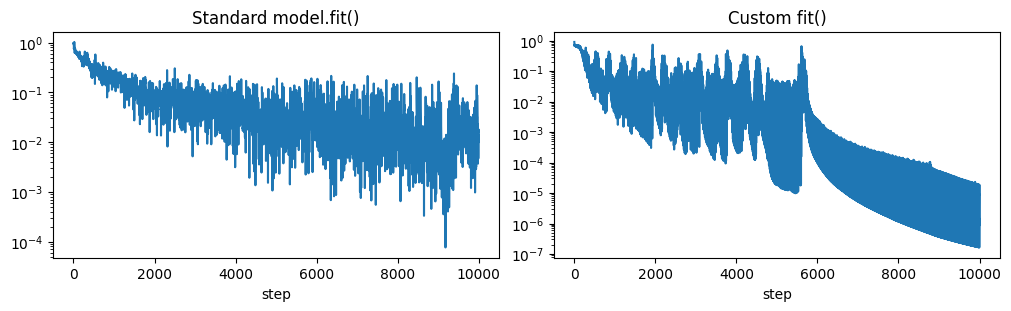

In [ ]:
# longer training time

# standard model.fit()
model_std = binary_classification_model('he_normal')
model_std.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_std = model_std.fit(dataset.batch(32), epochs=1000, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit(model_cust, dataset.batch(32), epochs=1000, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

It's interesting that my custom fit() function gets orders of magnitude better results when it works well. However, it's less stable and flatlines more often.

## Re-implementing starting from Keras version
Let's just a more vanilla copy-paste out of the Keras 3.5.0 codebase.

Epoch     1 - 3.00s/epoch: loss: 0.8586  
Epoch     2 - 36.15ms/epoch: loss: 0.7683  
Epoch     3 - 35.01ms/epoch: loss: 0.7269  
Epoch     4 - 35.95ms/epoch: loss: 0.6648  
Epoch     5 - 34.06ms/epoch: loss: 0.6100  
Epoch     6 - 88.05ms/epoch: loss: 0.6236  
Epoch     7 - 65.33ms/epoch: loss: 0.6228  
Epoch     8 - 66.84ms/epoch: loss: 0.5777  
Epoch     9 - 118.95ms/epoch: loss: 0.5969  
Epoch    10 - 35.65ms/epoch: loss: 0.5998  
Epoch     1 - 3.57s/epoch: loss: 0.9048  
Epoch     2 - 68.38ms/epoch: loss: 0.8221  
Epoch     3 - 60.36ms/epoch: loss: 0.7209  
Epoch     4 - 54.03ms/epoch: loss: 0.6439  
Epoch     5 - 71.41ms/epoch: loss: 0.6713  
Epoch     6 - 50.47ms/epoch: loss: 0.6737  
Epoch     7 - 54.41ms/epoch: loss: 0.6215  
Epoch     8 - 56.17ms/epoch: loss: 0.5537  
Epoch     9 - 62.88ms/epoch: loss: 0.5934  
Epoch    10 - 60.19ms/epoch: loss: 0.5655  


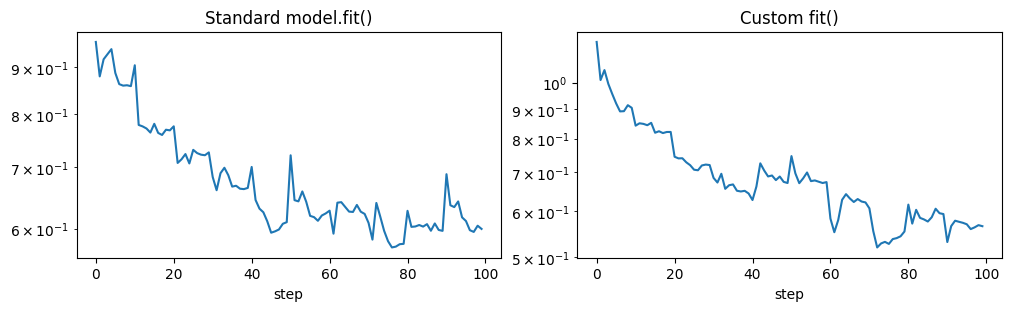

In [ ]:
# First version, exact copy from Keras 3.5.0's model.fit() method with minimal modifications to make it work here.
import contextlib
from tensorflow.python.eager import context as tf_context
from keras.src import callbacks as callbacks_module
from keras.src import metrics as metrics_module
from keras.src import optimizers as optimizers_module
from keras.src import tree
from keras.src.trainers import trainer as base_trainer
from keras.src.trainers.data_adapters import array_slicing
from keras.src.trainers.data_adapters import data_adapter_utils
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.utils import traceback_utils
from keras.src.backend.tensorflow.trainer import TFEpochIterator

def fit_verbatim1(model, x=None, y=None, batch_size=None, epochs=1, verbose="auto", callbacks=None, validation_split=0.0, validation_data=None,
       shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1):
    self = model

    self._assert_compile_called("fit")
    # TODO: respect compiled trainable state
    self._eval_epoch_iterator = None
    if validation_split and validation_data is None:
        # Create the validation data using the training data. Only supported
        # for TF/numpy/jax arrays.
        (
            x,
            y,
            sample_weight,
        ), validation_data = array_slicing.train_validation_split(
            (x, y, sample_weight), validation_split=validation_split
        )

    if validation_data is not None:
        (
            val_x,
            val_y,
            val_sample_weight,
        ) = data_adapter_utils.unpack_x_y_sample_weight(validation_data)

    # Create an iterator that yields batches for one epoch.
    epoch_iterator = TFEpochIterator(
        x=x,
        y=y,
        sample_weight=sample_weight,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        shuffle=shuffle,
        class_weight=class_weight,
        distribute_strategy=self.distribute_strategy,
        steps_per_execution=self.steps_per_execution,
    )

    self._maybe_symbolic_build(iterator=epoch_iterator)

    # Container that configures and calls callbacks.
    if not isinstance(callbacks, callbacks_module.CallbackList):
        callbacks = callbacks_module.CallbackList(
            callbacks,
            add_history=True,
            add_progbar=verbose != 0,
            verbose=verbose,
            epochs=epochs,
            steps=epoch_iterator.num_batches,
            model=self,
        )

    self.stop_training = False
    self.make_train_function()
    callbacks.on_train_begin()
    training_logs = None
    logs = {}
    initial_epoch = self._initial_epoch or initial_epoch
    for epoch in range(initial_epoch, epochs):
        self.reset_metrics()
        callbacks.on_epoch_begin(epoch)
        with epoch_iterator.catch_stop_iteration():
            for step, iterator in epoch_iterator.enumerate_epoch():
                callbacks.on_train_batch_begin(step)
                logs = self.train_function(iterator)
                #logs = self._pythonify_logs(logs)   # <-- couldn't translate
                callbacks.on_train_batch_end(step, logs)
                if self.stop_training:
                    break

        # Override with model metrics instead of last step logs if needed.
        epoch_logs = dict(self._get_metrics_result_or_logs(logs))

        # Run validation.
        if validation_data is not None and self._should_eval(
            epoch, validation_freq
        ):
            # Create EpochIterator for evaluation and cache it.
            if getattr(self, "_eval_epoch_iterator", None) is None:
                self._eval_epoch_iterator = TFEpochIterator(
                    x=val_x,
                    y=val_y,
                    sample_weight=val_sample_weight,
                    batch_size=validation_batch_size or batch_size,
                    distribute_strategy=self.distribute_strategy,
                    steps_per_execution=self.steps_per_execution,
                    steps_per_epoch=validation_steps,
                    shuffle=False,
                )
            val_logs = self.evaluate(
                x=val_x,
                y=val_y,
                sample_weight=val_sample_weight,
                batch_size=validation_batch_size or batch_size,
                steps=validation_steps,
                callbacks=callbacks,
                return_dict=True,
                _use_cached_eval_dataset=True,
            )
            val_logs = {
                "val_" + name: val for name, val in val_logs.items()
            }
            epoch_logs.update(val_logs)

        callbacks.on_epoch_end(epoch, epoch_logs)
        training_logs = epoch_logs
        if self.stop_training:
            break

    if (isinstance(self.optimizer, optimizers_module.Optimizer) and epochs > 0):
        self.optimizer.finalize_variable_values(self.trainable_weights)

    # If _eval_epoch_iterator exists, delete it after all epochs are done.
    if getattr(self, "_eval_epoch_iterator", None) is not None:
        del self._eval_epoch_iterator
    callbacks.on_train_end(logs=training_logs)
    return self.history

# standard model.fit()
model_std = binary_classification_model('he_normal')
model_std.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_std = model_std.fit(dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit_verbatim1(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

.........Running trial 1/10.........
.........Running trial 2/10.........
.........Running trial 3/10.........
.........Running trial 4/10.........
.........Running trial 5/10.........
.........Running trial 6/10.........
.........Running trial 7/10.........
.........Running trial 8/10.........
.........Running trial 9/10.........
.........Running trial 10/10.........
.........10 trials completed............


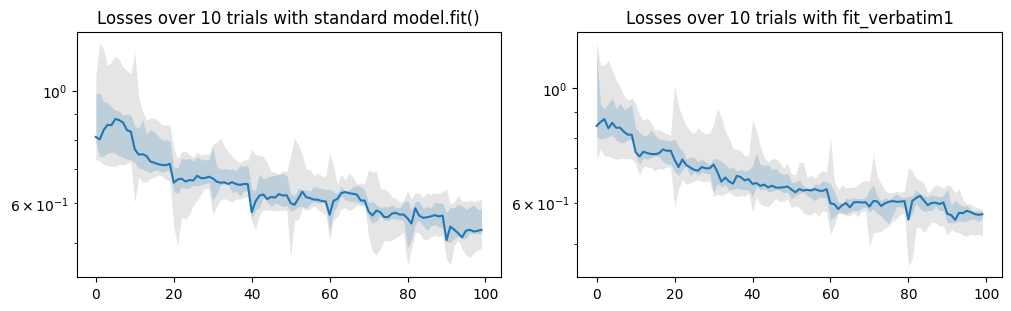

In [ ]:
# custom fit()
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
def one_trial():
  model = binary_classification_model('he_normal')
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return fit_verbatim1(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.HistoryStats(per_step=True)])

cust_trial_stats = run_multi(num_trials=10, func=one_trial)
#plot_trials(cust_trial_stats, num_trials=10, title="Losses over 10 trials with fit_verbatim1")
compare_trials(std_trial_stats, cust_trial_stats, "fit_verbatim1", num_trials=10)


Now let's start modifying the verbatim version more towards my custom version.

Epoch     1 - 3.69s/epoch: loss: 0.7443  
Epoch     2 - 42.14ms/epoch: loss: 0.7018  
Epoch     3 - 46.30ms/epoch: loss: 0.7120  
Epoch     4 - 35.68ms/epoch: loss: 0.6661  
Epoch     5 - 63.14ms/epoch: loss: 0.6835  
Epoch     6 - 37.87ms/epoch: loss: 0.6548  
Epoch     7 - 37.50ms/epoch: loss: 0.5855  
Epoch     8 - 42.35ms/epoch: loss: 0.5681  
Epoch     9 - 43.10ms/epoch: loss: 0.5660  
Epoch    10 - 59.67ms/epoch: loss: 0.5607  


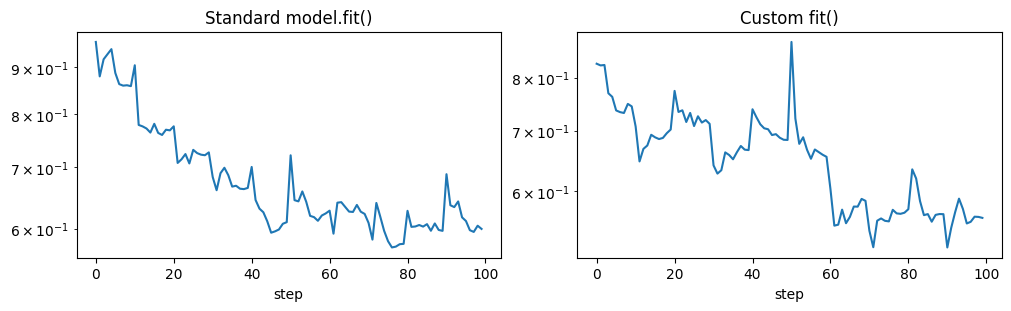

In [ ]:
# changes:
# - directly call model.train_step()
# - remove support for validation.
import contextlib
from tensorflow.python.eager import context as tf_context
from keras.src import callbacks as callbacks_module
from keras.src import metrics as metrics_module
from keras.src import optimizers as optimizers_module
from keras.src import tree
from keras.src.trainers import trainer as base_trainer
from keras.src.trainers.data_adapters import array_slicing
from keras.src.trainers.data_adapters import data_adapter_utils
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.utils import traceback_utils
from keras.src.backend.tensorflow.trainer import TFEpochIterator

@tf.function
def one_train_step(model, data):
  return model.train_step(data)

def fit_verbatim2(model, x=None, y=None, batch_size=None, epochs=1, verbose="auto", callbacks=None,
       shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None):
    self = model

    self._assert_compile_called("fit")
    # TODO: respect compiled trainable state
    self._eval_epoch_iterator = None

    # Create an iterator that yields batches for one epoch.
    epoch_iterator = TFEpochIterator(
        x=x,
        y=y,
        sample_weight=sample_weight,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        shuffle=shuffle,
        class_weight=class_weight,
        distribute_strategy=self.distribute_strategy,
        steps_per_execution=self.steps_per_execution,
    )

    self._maybe_symbolic_build(iterator=epoch_iterator)

    # Container that configures and calls callbacks.
    if not isinstance(callbacks, callbacks_module.CallbackList):
        callbacks = callbacks_module.CallbackList(
            callbacks,
            add_history=True,
            add_progbar=verbose != 0,
            verbose=verbose,
            epochs=epochs,
            steps=epoch_iterator.num_batches,
            model=self,
        )

    self.stop_training = False
    self.make_train_function()
    callbacks.on_train_begin()
    training_logs = None
    logs = {}
    initial_epoch = self._initial_epoch or initial_epoch
    for epoch in range(initial_epoch, epochs):
        self.reset_metrics()
        callbacks.on_epoch_begin(epoch)
        with epoch_iterator.catch_stop_iteration():
            for step, iterator in epoch_iterator.enumerate_epoch():
                callbacks.on_train_batch_begin(step)
                #logs = self.train_function(iterator)
                logs = one_train_step(model, next(iterator))
                callbacks.on_train_batch_end(step, logs)
                if self.stop_training:
                    break

        # Override with model metrics instead of last step logs if needed.
        epoch_logs = dict(self._get_metrics_result_or_logs(logs))

        callbacks.on_epoch_end(epoch, epoch_logs)
        training_logs = epoch_logs
        if self.stop_training:
            break

    #if (isinstance(self.optimizer, optimizers_module.Optimizer) and epochs > 0):
    #    self.optimizer.finalize_variable_values(self.trainable_weights)

    # If _eval_epoch_iterator exists, delete it after all epochs are done.
    if getattr(self, "_eval_epoch_iterator", None) is not None:
        del self._eval_epoch_iterator
    callbacks.on_train_end(logs=training_logs)
    return self.history

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit_verbatim2(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

Epoch     1 - 3.06s/epoch: loss: 0.8207  
Epoch     2 - 34.33ms/epoch: loss: 0.7060  
Epoch     3 - 32.78ms/epoch: loss: 0.7446  
Epoch     4 - 33.02ms/epoch: loss: 0.6709  
Epoch     5 - 33.31ms/epoch: loss: 0.5994  
Epoch     6 - 33.32ms/epoch: loss: 0.5961  
Epoch     7 - 70.23ms/epoch: loss: 0.6169  
Epoch     8 - 34.04ms/epoch: loss: 0.5554  
Epoch     9 - 33.64ms/epoch: loss: 0.5724  
Epoch    10 - 33.10ms/epoch: loss: 0.5103  


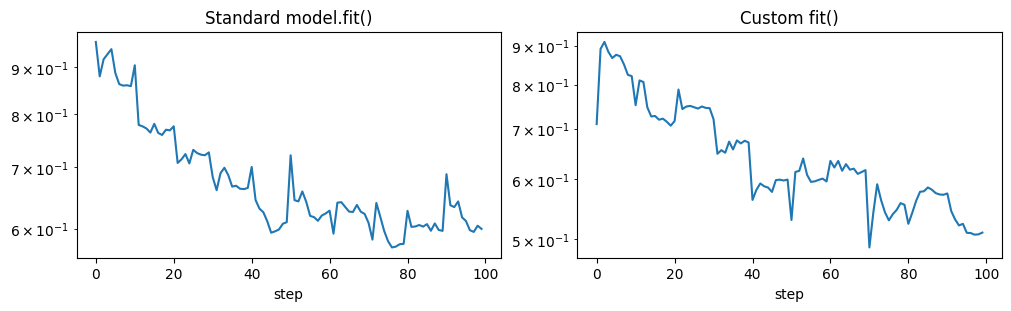

In [ ]:
# changes:
# - using my own dataset iteration
import contextlib
from tensorflow.python.eager import context as tf_context
from keras.src import callbacks as callbacks_module
from keras.src import metrics as metrics_module
from keras.src import optimizers as optimizers_module
from keras.src import tree
from keras.src.trainers import trainer as base_trainer
from keras.src.trainers.data_adapters import array_slicing
from keras.src.trainers.data_adapters import data_adapter_utils
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.utils import traceback_utils
from keras.src.backend.tensorflow.trainer import TFEpochIterator

# manually converted via tf.function
def one_train_step(model, data):
  return model.train_step(data)

def fit_verbatim3(model, dataset, epochs=1, initial_epoch=0, verbose="auto", callbacks=None):
    self = model
    self._assert_compile_called("fit")
    self._eval_epoch_iterator = None

    # Container that configures and calls callbacks.
    if not isinstance(callbacks, callbacks_module.CallbackList):
        callbacks = callbacks_module.CallbackList(
            callbacks,
            add_history=True,
            add_progbar=verbose != 0,
            verbose=verbose,
            epochs=epochs,
            steps=32,  ## assumed
            model=self,
        )

    train_step_fn = tf.function(one_train_step, reduce_retracing=True)

    self.stop_training = False
    self.make_train_function()
    callbacks.on_train_begin()
    training_logs = None
    logs = {}
    initial_epoch = self._initial_epoch or initial_epoch
    for epoch in range(initial_epoch, epochs):
        self.reset_metrics()
        callbacks.on_epoch_begin(epoch)
        for step, data in enumerate(dataset):
            callbacks.on_train_batch_begin(step)
            logs = train_step_fn(model, data)
            callbacks.on_train_batch_end(step, logs)
            if self.stop_training:
                break

        # Override with model metrics instead of last step logs if needed.
        epoch_logs = dict(self._get_metrics_result_or_logs(logs))

        callbacks.on_epoch_end(epoch, epoch_logs)
        training_logs = epoch_logs
        if self.stop_training:
            break

    callbacks.on_train_end(logs=training_logs)
    return self.history

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit_verbatim3(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

.........Running trial 1/10.........
.........Running trial 2/10.........
.........Running trial 3/10.........
.........Running trial 4/10.........
.........Running trial 5/10.........
.........Running trial 6/10.........
.........Running trial 7/10.........
.........Running trial 8/10.........
.........Running trial 9/10.........
.........Running trial 10/10.........
.........10 trials completed............


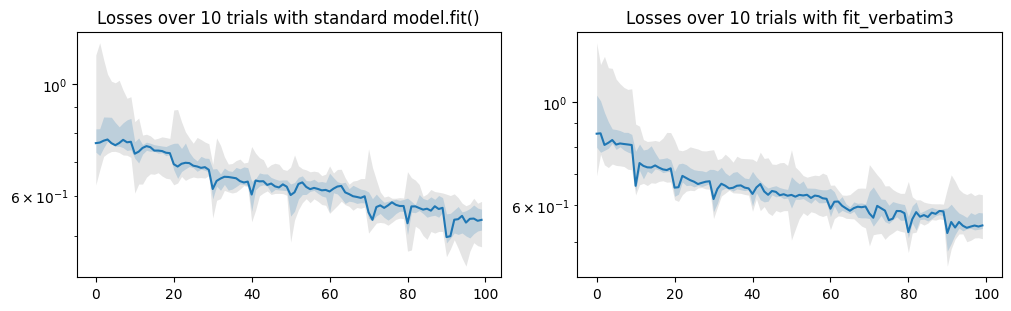

In [ ]:
# custom fit()
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
def one_trial():
  model = binary_classification_model('he_normal')
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return fit_verbatim3(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.HistoryStats(per_step=True)])

cust_trial_stats = run_multi(num_trials=10, func=one_trial)
compare_trials(std_trial_stats, cust_trial_stats, "fit_verbatim3", num_trials=10)

Still in sync.

Next steps:
* remove those extra sugar calls
* modify to collect return gradients

Epoch     1 - 3.33s/epoch: loss: 0.8465  
Epoch     2 - 39.96ms/epoch: loss: 0.8015  
Epoch     3 - 50.79ms/epoch: loss: 0.7509  
Epoch     4 - 36.68ms/epoch: loss: 0.6803  
Epoch     5 - 34.63ms/epoch: loss: 0.6720  
Epoch     6 - 35.74ms/epoch: loss: 0.6654  
Epoch     7 - 39.49ms/epoch: loss: 0.6207  
Epoch     8 - 71.93ms/epoch: loss: 0.6135  
Epoch     9 - 37.76ms/epoch: loss: 0.6002  
Epoch    10 - 34.22ms/epoch: loss: 0.5772  


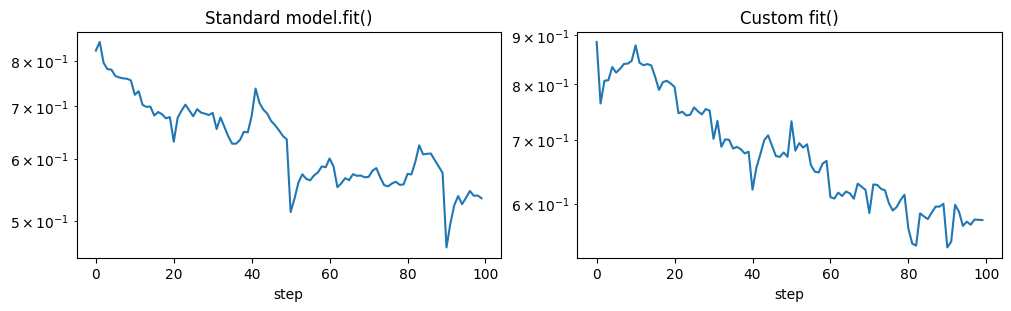

In [12]:
# changes:
# - pull model.train_step() as a function here instead
import contextlib
from tensorflow.python.eager import context as tf_context
from keras.src import callbacks as callbacks_module
from keras.src import metrics as metrics_module
from keras.src import optimizers as optimizers_module
from keras.src import tree
from keras.src.trainers import trainer as base_trainer
from keras.src.trainers.data_adapters import array_slicing
from keras.src.trainers.data_adapters import data_adapter_utils
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.utils import traceback_utils
from keras.src.backend.tensorflow.trainer import TFEpochIterator

# manually converted via tf.function
def one_train_step(model, data):
    self = model
    x, y, sample_weight = data_adapter_utils.unpack_x_y_sample_weight(data)

    # Forward pass
    with tf.GradientTape() as tape:
        #if self._call_has_training_arg:
        #    y_pred = self(x, training=True)
        #else:
        #    y_pred = self(x) # Keras 3.5.0 model.train_setp()
        #loss = self._compute_loss(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight, training=True)  # Keras 3.5.0 model.train_setp()
        y_pred = self(x, training=True)
        loss = self.compute_loss(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight, training=True)
        self._loss_tracker.update_state(loss, sample_weight=tf.shape(tree.flatten(x)[0])[0])
        if self.optimizer is not None:
            loss = self.optimizer.scale_loss(loss)

    # Compute gradients
    if self.trainable_weights:
        trainable_weights = self.trainable_weights
        gradients = tape.gradient(loss, trainable_weights)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))
    else:
        raise ValueError("The model does not have any trainable weights.")

    return self.compute_metrics(x, y, y_pred, sample_weight=sample_weight)

def fit_verbatim4(model, dataset, epochs=1, initial_epoch=0, verbose="auto", callbacks=None):
    self = model
    self._assert_compile_called("fit")
    self._eval_epoch_iterator = None

    # Container that configures and calls callbacks.
    if not isinstance(callbacks, callbacks_module.CallbackList):
        callbacks = callbacks_module.CallbackList(
            callbacks,
            add_history=True,
            add_progbar=verbose != 0,
            verbose=verbose,
            epochs=epochs,
            steps=32,  ## assumed
            model=self,
        )

    train_step_fn = tf.function(one_train_step, reduce_retracing=True)

    self.stop_training = False
    self.make_train_function()
    callbacks.on_train_begin()
    training_logs = None
    logs = {}
    initial_epoch = self._initial_epoch or initial_epoch
    for epoch in range(initial_epoch, epochs):
        self.reset_metrics()
        callbacks.on_epoch_begin(epoch)
        for step, data in enumerate(dataset):
            callbacks.on_train_batch_begin(step)
            logs = train_step_fn(model, data)
            callbacks.on_train_batch_end(step, logs)
            if self.stop_training:
                break

        # Override with model metrics instead of last step logs if needed.
        epoch_logs = dict(self._get_metrics_result_or_logs(logs))

        callbacks.on_epoch_end(epoch, epoch_logs)
        training_logs = epoch_logs
        if self.stop_training:
            break

    callbacks.on_train_end(logs=training_logs)
    return self.history

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit_verbatim4(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

Epoch     1 - 5.41s/epoch: loss: 0.0000  
Epoch     2 - 40.46ms/epoch: loss: 0.0000  
Epoch     3 - 37.01ms/epoch: loss: 0.0000  
Epoch     4 - 40.78ms/epoch: loss: 0.0000  
Epoch     5 - 39.88ms/epoch: loss: 0.0000  
Epoch     6 - 71.62ms/epoch: loss: 0.0000  
Epoch     7 - 40.11ms/epoch: loss: 0.0000  
Epoch     8 - 35.53ms/epoch: loss: 0.0000  
Epoch     9 - 35.39ms/epoch: loss: 0.0000  
Epoch    10 - 46.84ms/epoch: loss: 0.0000  


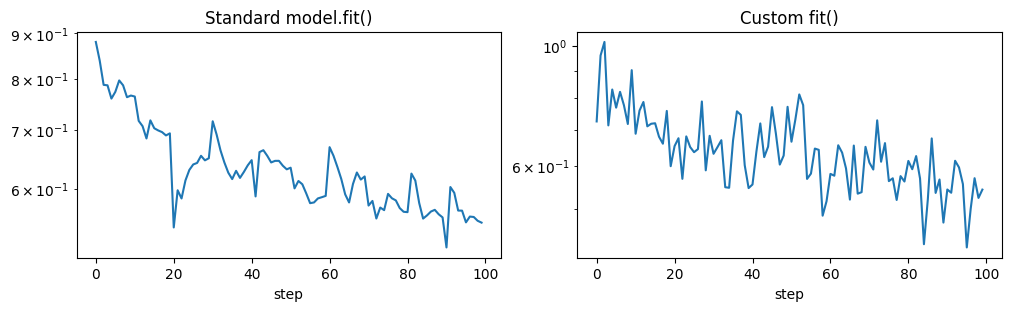

In [27]:
# changes:
# - modified one_train_step() towards how custom fit() does it
# - except added training=True because I just discovered I'd missed that out in the custom fit()
import contextlib
from tensorflow.python.eager import context as tf_context
from keras.src import callbacks as callbacks_module
from keras.src import metrics as metrics_module
from keras.src import optimizers as optimizers_module
from keras.src import tree
from keras.src.trainers import trainer as base_trainer
from keras.src.trainers.data_adapters import array_slicing
from keras.src.trainers.data_adapters import data_adapter_utils
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.utils import traceback_utils
from keras.src.backend.tensorflow.trainer import TFEpochIterator

# manually converted via tf.function
def one_train_step(model, data):
    self = model
    x, y, sample_weight = data_adapter_utils.unpack_x_y_sample_weight(data)

    # Forward pass
    with tf.GradientTape() as tape:
        # y_pred = self(x, training=True)
        # loss = self.compute_loss(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight, training=True)
        # self._loss_tracker.update_state(loss, sample_weight=tf.shape(tree.flatten(x)[0])[0])
        # if self.optimizer is not None:
        #     loss = self.optimizer.scale_loss(loss)

        y_pred = model(x, training=True)   # note: baseline custom fit() didn't pass training=True
        loss = model.compute_loss(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight, training=True)
        reported_loss = loss  # tracking before scaling
        loss = model.optimizer.scale_loss(loss)

    # Compute gradients
    # if self.trainable_weights:
    #     trainable_weights = self.trainable_weights
    #     gradients = tape.gradient(loss, trainable_weights)

    #     # Update weights
    #     self.optimizer.apply_gradients(zip(gradients, trainable_weights))
    if self.trainable_variables:
        trainable_variables = self.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    else:
        raise ValueError("The model does not have any trainable weights.")

    metrics = self.compute_metrics(x, y, y_pred, sample_weight=sample_weight)
    return reported_loss, metrics

def fit_verbatim4(model, dataset, epochs=1, initial_epoch=0, verbose="auto", callbacks=None):
    self = model
    self._assert_compile_called("fit")
    self._eval_epoch_iterator = None

    # Container that configures and calls callbacks.
    if not isinstance(callbacks, callbacks_module.CallbackList):
        callbacks = callbacks_module.CallbackList(
            callbacks,
            add_history=True,
            add_progbar=verbose != 0,
            verbose=verbose,
            epochs=epochs,
            steps=32,  ## assumed
            model=self,
        )

    train_step_fn = tf.function(one_train_step, reduce_retracing=True)

    self.stop_training = False
    self.make_train_function()
    callbacks.on_train_begin()
    training_logs = None
    logs = {}
    initial_epoch = self._initial_epoch or initial_epoch
    for epoch in range(initial_epoch, epochs):
        self.reset_metrics()
        callbacks.on_epoch_begin(epoch)
        for step, data in enumerate(dataset):
            callbacks.on_train_batch_begin(step)
            loss, metrics = train_step_fn(model, data)
            logs = metrics
            logs['loss'] = loss.numpy()
            callbacks.on_train_batch_end(step, logs)
            if self.stop_training:
                break

        # Override with model metrics instead of last step logs if needed.
        epoch_logs = dict(self._get_metrics_result_or_logs(logs))

        callbacks.on_epoch_end(epoch, epoch_logs)
        training_logs = epoch_logs
        if self.stop_training:
            break

    callbacks.on_train_end(logs=training_logs)
    return self.history

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit_verbatim4(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

Epoch     1 - 3.68s/epoch: loss: 0.8063  
Epoch     2 - 39.89ms/epoch: loss: 0.7554  
Epoch     3 - 35.52ms/epoch: loss: 0.7082  
Epoch     4 - 35.30ms/epoch: loss: 0.6502  
Epoch     5 - 38.29ms/epoch: loss: 0.6254  
Epoch     6 - 38.54ms/epoch: loss: 0.6123  
Epoch     7 - 40.07ms/epoch: loss: 0.6512  
Epoch     8 - 36.18ms/epoch: loss: 0.5798  
Epoch     9 - 73.23ms/epoch: loss: 0.5860  
Epoch    10 - 72.13ms/epoch: loss: 0.5806  


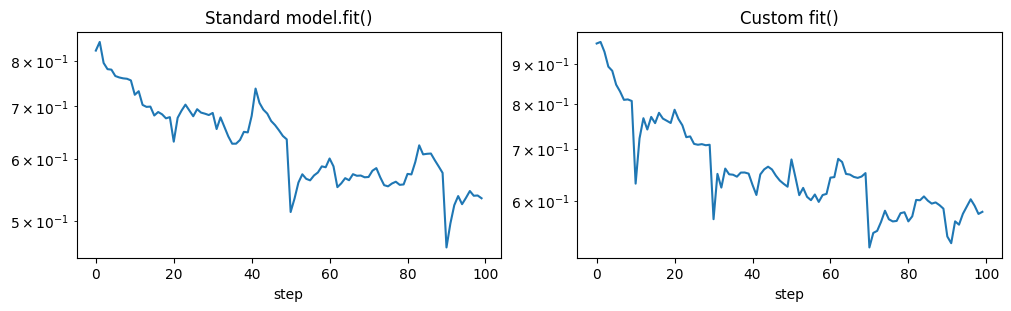

In [23]:
# changes:
# - reverted back to Keras way of passing loss metric around
# learnings so far:
# - model(x) call must include `training=True`. Definitely a very poor equivalent without that.
#   Probably because things like batch normalization depend on a different learning strategy and aren't updated by gradients alone.
# - the loss tracking seems to also be a big cause of discrepancies. It applies a mean across the losses throughout the epoch
#   so that the reported loss is the average over the whole epoch, rather than the last loss from the last batch update.
#   This explains why my custom fit() function has produced much more spiky loss plots.
import contextlib
from tensorflow.python.eager import context as tf_context
from keras.src import callbacks as callbacks_module
from keras.src import metrics as metrics_module
from keras.src import optimizers as optimizers_module
from keras.src import tree
from keras.src.trainers import trainer as base_trainer
from keras.src.trainers.data_adapters import array_slicing
from keras.src.trainers.data_adapters import data_adapter_utils
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.trainers.epoch_iterator import EpochIterator
from keras.src.utils import traceback_utils
from keras.src.backend.tensorflow.trainer import TFEpochIterator

# manually converted via tf.function
def one_train_step(model, data):
    self = model
    x, y, sample_weight = data_adapter_utils.unpack_x_y_sample_weight(data)

    # Forward pass
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)  # definitely has an effect if missed out
        loss = model.compute_loss(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight, training=True)
        self._loss_tracker.update_state(loss, sample_weight=tf.shape(tree.flatten(x)[0])[0])
        loss = model.optimizer.scale_loss(loss)

    # Compute gradients
    # if self.trainable_weights:
    #     trainable_weights = self.trainable_weights
    #     gradients = tape.gradient(loss, trainable_weights)

    #     # Update weights
    #     self.optimizer.apply_gradients(zip(gradients, trainable_weights))
    if self.trainable_variables:  # note: according to Keras code, this is equivalent to calling model.trainable_weights
        trainable_variables = self.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    else:
        raise ValueError("The model does not have any trainable weights.")

    return self.compute_metrics(x, y, y_pred, sample_weight=sample_weight)

def fit_verbatim4(model, dataset, epochs=1, initial_epoch=0, verbose="auto", callbacks=None):
    self = model
    self._assert_compile_called("fit")
    self._eval_epoch_iterator = None

    # Container that configures and calls callbacks.
    if not isinstance(callbacks, callbacks_module.CallbackList):
        callbacks = callbacks_module.CallbackList(
            callbacks,
            add_history=True,
            add_progbar=verbose != 0,
            verbose=verbose,
            epochs=epochs,
            steps=32,  ## assumed
            model=self,
        )

    train_step_fn = tf.function(one_train_step, reduce_retracing=True)

    self.stop_training = False
    self.make_train_function()
    callbacks.on_train_begin()
    training_logs = None
    logs = {}
    initial_epoch = self._initial_epoch or initial_epoch
    for epoch in range(initial_epoch, epochs):
        self.reset_metrics()
        callbacks.on_epoch_begin(epoch)
        for step, data in enumerate(dataset):
            callbacks.on_train_batch_begin(step)
            logs = train_step_fn(model, data)
            callbacks.on_train_batch_end(step, logs)
            if self.stop_training:
                break

        # Override with model metrics instead of last step logs if needed.
        epoch_logs = dict(self._get_metrics_result_or_logs(logs))

        callbacks.on_epoch_end(epoch, epoch_logs)
        training_logs = epoch_logs
        if self.stop_training:
            break

    callbacks.on_train_end(logs=training_logs)
    return self.history

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit_verbatim4(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

## Learnings
* I was missing out model(x, training=True), causing the learning curve to be poorer in some cases because other non-gradient learning wasn't happening.
* I was taking the _last_ loss at the end of each epoch, instead of averaging over the course of the epoch.
* I've also seen that it's very easy to copy paste out of Keras to include all of its nuances, so I could use a more vanilla Keras codebase as the starting point for my custom fit function and do a lot of good for myself.

**Next steps**:

* Prove that a simple fixed version of the existing fit() function will behave the same as the main fit function, then...
* Incorporate more from the Keras codebase into my fit() function.

Epoch     1 - 3.22s/epoch: loss: 0.7653  
Epoch     2 - 74.93ms/epoch: loss: 0.6932  
Epoch     3 - 127.76ms/epoch: loss: 0.6495  
Epoch     4 - 68.20ms/epoch: loss: 0.6377  
Epoch     5 - 69.06ms/epoch: loss: 0.6310  
Epoch     6 - 53.44ms/epoch: loss: 0.5887  
Epoch     7 - 59.90ms/epoch: loss: 0.6194  
Epoch     8 - 61.15ms/epoch: loss: 0.5647  
Epoch     9 - 61.83ms/epoch: loss: 0.5565  
Epoch    10 - 63.69ms/epoch: loss: 0.5490  
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_473']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_473']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


Epoch     1 - 4.15s/epoch: loss: 0.8843  
Epoch     2 - 40.20ms/epoch: loss: 0.8297  
Epoch     3 - 39.94ms/epoch: loss: 0.7909  
Epoch     4 - 41.22ms/epoch: loss: 0.7000  
Epoch     5 - 41.71ms/epoch: loss: 0.7038  
Epoch     6 - 46.46ms/epoch: loss: 0.6857  
Epoch     7 - 73.61ms/epoch: loss: 0.6408  
Epoch     8 - 39.04ms/epoch: loss: 0.6353  
Epoch     9 - 39.13ms/epoch: loss: 0.6077  
Epoch    10 - 51.37ms/epoch: loss: 0.6109  


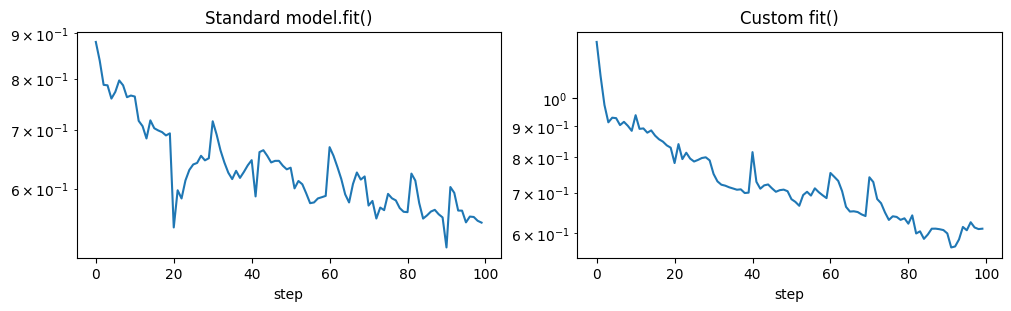

In [25]:
# partially simplified version of custom fit() from above, but with fixes:
# - passes training=True
# - uses model._loss_tracker
def fit(model, dataset, epochs=1, verbose=1, callbacks=None, initial_epoch=0):
    # prepare epochs
    num_batches = len(dataset)

    # prepare callbacks tracking
    if not isinstance(callbacks, tf.keras.callbacks.CallbackList):
      callbacks = tf.keras.callbacks.CallbackList(callbacks, add_history=True, add_progbar=verbose != 0,
                                                  verbose=verbose, epochs=epochs, steps=num_batches, model=model)

    monitoring_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=[model.outputs] + [layer.output for layer in model.layers])

    # prepare train function
    if tf.config.functions_run_eagerly():
        train_step_fn = _gradient_returning_train_step
    else:
        train_step_fn = tf.function(_gradient_returning_train_step)

    # latest values
    # - these are computed at each step, but we need to provide values at the end of each epoch,
    #   so we'll just hold onto the last value computed at each step
    logs = {}
    loss = None
    trainable_gradients = None
    output_gradients = None
    activations = None

    # train
    print(f"Temporary custom fit() function")
    callbacks.on_train_begin()
    for epoch in range(initial_epoch, epochs):
        model.reset_metrics()
        callbacks.on_epoch_begin(epoch)

        for step, data in enumerate(dataset):
            x, y, sample_weight = keras.utils.unpack_x_y_sample_weight(data)
            callbacks.on_train_batch_begin(step)
            metrics, trainable_gradients, output_gradients, activations = train_step_fn(
                model, monitoring_model, x, y, sample_weight, compute_output_gradients=False)

            logs = metrics     # <---- CHANGE
            callbacks.on_train_batch_end(step, logs)

        # end of epoch
        callbacks.on_epoch_end(epoch, logs)  # should be passing loss and mse
    callbacks.on_train_end(logs)
    return model.history

def _gradient_returning_train_step(model, monitoring_model, x, y, sample_weight, compute_output_gradients):
    # Forward pass
    with tf.GradientTape() as tape:
        monitoring_outputs = monitoring_model(x, training=True)  # <------ CHANGE
        y_pred = monitoring_outputs[0]
        layer_outputs = monitoring_outputs[1:]

        loss = model.compute_loss(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight, training=True)
        reported_loss = loss  # tracking before scaling
        model._loss_tracker.update_state(loss, sample_weight=tf.shape(tree.flatten(x)[0])[0])
        loss = model.optimizer.scale_loss(loss)


    # Backward pass
    if compute_output_gradients:
        gradients = tape.gradient(loss, model.trainable_weights + layer_outputs)
        trainable_grads = gradients[:len(model.trainable_variables)]
        output_grads = gradients[len(model.trainable_variables):]
    else:
        trainable_grads = tape.gradient(loss, model.trainable_variables)
        output_grads = None
    model.optimizer.apply_gradients(zip(trainable_grads, model.trainable_variables))

    # Metrics
    metrics = model.compute_metrics(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight)

    return metrics, trainable_grads, output_grads, layer_outputs

# custom fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = fit(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

.........Running trial 1/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_484']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_484']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........Running trial 2/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_495']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_495']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........Running trial 3/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_506']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_506']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........Running trial 4/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_517']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_517']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........Running trial 5/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_528']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_528']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........Running trial 6/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_539']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_539']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........Running trial 7/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_550']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_550']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........Running trial 8/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_561']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_561']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........Running trial 9/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_572']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_572']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........Running trial 10/10.........
Temporary custom fit() function


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_583']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_583']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


.........10 trials completed............


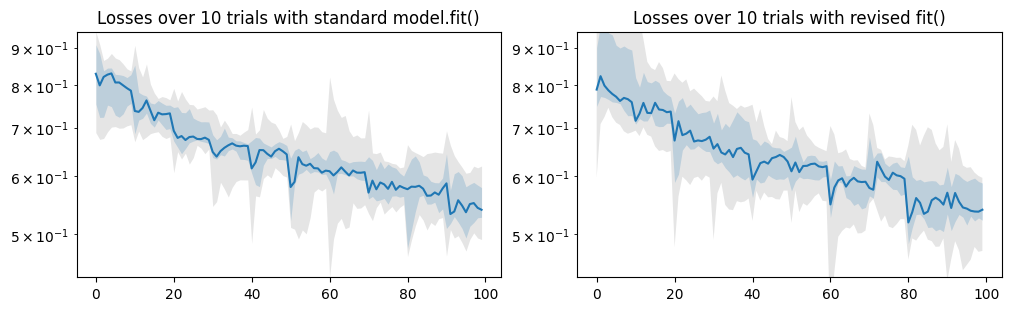

In [26]:
# custom fit()
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
def one_trial():
  model = binary_classification_model('he_normal')
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.HistoryStats(per_step=True)])

cust_trial_stats = run_multi(num_trials=10, func=one_trial)
compare_trials(std_trial_stats, cust_trial_stats, "revised fit()", num_trials=10)

**Success!**

## Revised fit() function

In [71]:
# update to later codebase
!cd repo && git checkout fdbfbf5
!cd repo && git pull

import train_observability_toolkit as tot
reload(tot)

Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 297 bytes | 42.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   76b8b31..fdbfbf5  main       -> origin/main
Updating 76b8b31..fdbfbf5
Fast-forward
 train_observability_toolkit.py | 1 -
 1 file changed, 1 deletion(-)


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

Training via custom fit() function. Will produce a few warnings; you can usually ignore these.
Epoch     1 - 3.32s/epoch: loss: 0.7246  
Epoch     2 - 42.97ms/epoch: loss: 0.6766  
Epoch     3 - 41.99ms/epoch: loss: 0.6866  
Epoch     4 - 42.15ms/epoch: loss: 0.6504  
Epoch     5 - 41.21ms/epoch: loss: 0.6386  
Epoch     6 - 49.83ms/epoch: loss: 0.6266  
Epoch     7 - 42.88ms/epoch: loss: 0.6222  
Epoch     8 - 43.43ms/epoch: loss: 0.5856  
Epoch     9 - 66.58ms/epoch: loss: 0.5894  
Epoch    10 - 46.95ms/epoch: loss: 0.5590  


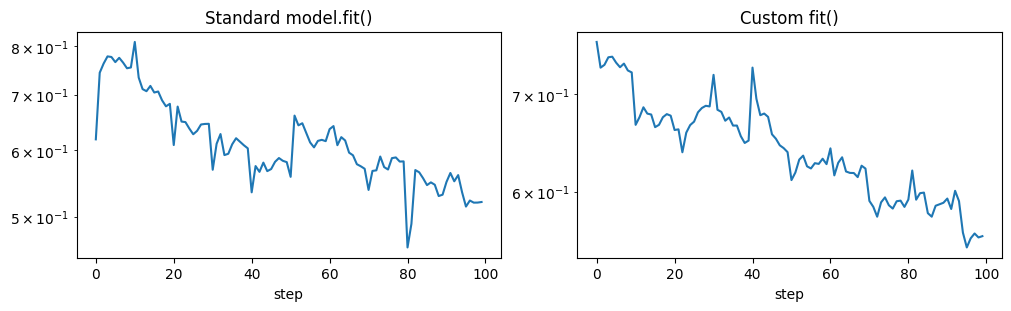

In [69]:
# new tot.fit()
model_cust = binary_classification_model('he_normal')
model_cust.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history_cust = tot.fit(model_cust, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=True)])

plot_fits(history_std, history_cust)

.........Running trial 1/10.........
.........Running trial 2/10.........
.........Running trial 3/10.........
.........Running trial 4/10.........
.........Running trial 5/10.........
.........Running trial 6/10.........
.........Running trial 7/10.........
.........Running trial 8/10.........
.........Running trial 9/10.........
.........Running trial 10/10.........
.........10 trials completed............


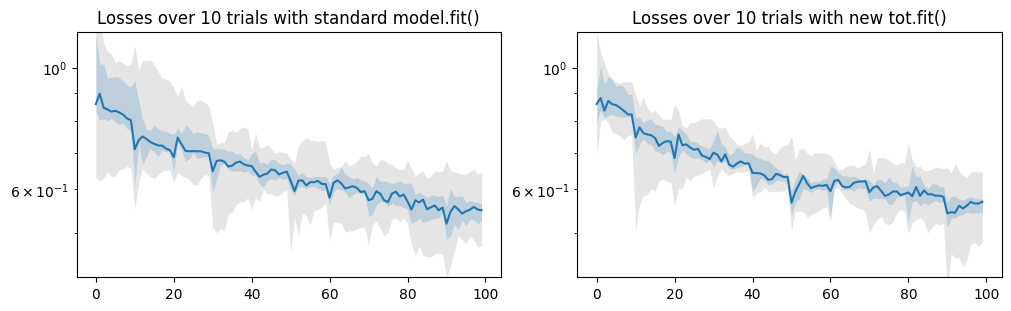

In [72]:
# new tot.fit()
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
def one_trial():
  model = binary_classification_model('he_normal')
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return tot.fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.HistoryStats(per_step=True)])

cust_trial_stats = run_multi(num_trials=10, func=one_trial)
compare_trials(std_trial_stats, cust_trial_stats, "new tot.fit()", num_trials=10)